# Data Processing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import fft, fftfreq
from pydub import AudioSegment
import matplotlib
from pydub.playback import play
from collections import deque 

In [3]:
class Analyzer:

    def __init__(self, file_path,source='Sound_Files/'):
        self.audio = AudioSegment.from_wav(source+file_path)
        self.file_name = file_path
        self.SAMPLE_RATE, self.data = wav.read(source+file_path)
        self.DURATION = len(self.audio)/1000
        self.xf, self.stft_out = None, None

    def play_file(self):
        return self.audio

    def split_audio(self, k=1):

        s = np.round(len(self.audio)/k)
        return [self.audio[i*s:(i+1)*s] for i in range(k)]
        # return np.split(self.audio,k)

    def get_data(self):
        return self.data

    def fft(self):
        clip_duration = 0.5
        end_index = int(np.rint(self.data.shape[0] * (clip_duration / self.DURATION))) # 1st 500 ms of audio
        clip_data = self.data[:end_index]

        duration = clip_duration
        # N = self.SAMPLE_RATE * self.DURATION
        N = int(self.SAMPLE_RATE * duration)

        self.xf = fftfreq(N, 1 / self.SAMPLE_RATE)
        return self.xf,fft(clip_data)

    def plot(self, l, r,save_path,k=1,lim=1,rows=1,my_top=0.9):
        cols = int(k/rows)
        fig, axs = plt.subplots(rows,cols,figsize=(20,3*rows))
        cur_data, cur_out = self.stft(k)
        fig.suptitle('File ' + self.file_name)
        fig.subplots_adjust(top=my_top)
        if lim > len(cur_out):
            lim = len(cur_out)
        cur_out = cur_out[:lim]
        for i in range(lim):
            x = int(i/cols)
            y = i%cols
            if k == 1:
                cur_ax = axs
            else:
                if rows == 1:
                    cur_ax = axs[y]
                else:
                    cur_ax = axs[x,y]
            cur_ax.title.set_text('Split ' + str(i+1))
            cur_ax.plot(cur_data,np.abs(cur_out[i]))

            cur_ax.set_ylim(0,2e7)
            cur_ax.set_xlim(l,r)
        if k==1:
            axs.set(xlabel='Frequencies', ylabel='Amplitudes')
        else:
            for ax in axs.flat:
                ax.set(xlabel='Frequencies', ylabel='Amplitudes')

            # Hide x labels and tick labels for top plots and y ticks for right plots.
            for ax in axs.flat:
                ax.label_outer()

        fig.subplots_adjust(hspace=.2)
        plt.savefig('STFT_Graphs/' + save_path)


        plt.show()

In [235]:
NUM_FREQS = 7

def filter_signal(old_x,old_y):
    # Filter frequencies 0-5000
    l = -1
    r = -1
    for i in range(len(old_x)):
        if old_x[i] >= 0 and l == -1:
            l = i
        if old_x[i] > 5000 and r == -1:
            r = i
    x = old_x[l:r]
    y = old_y[l:r]
    
    # Find local maxima
    local_maxima_x = []
    local_maxima_y = []
    HALFWAY_NOTE_DOWN_RATIO = 2 ** (1/24) # sqrt of the ratio of the freq of any note to one note lower
    queue = deque([0]) 
    maxima_flags = [False] * x.shape[0]
    cur_index = 1
    while cur_index < x.shape[0]:
        if y[cur_index] >= y[queue[0]]:
            # clear queue only if new potential maxima found
            queue.clear()
            maxima_flags[cur_index] = True        
        queue.append(cur_index)
            
        # if value in queue moves out of the range, check if maxima and then remove
        if queue[0] <= cur_index / HALFWAY_NOTE_DOWN_RATIO:
            if maxima_flags[queue[0]]:
                local_maxima_x.append(x[queue[0]])
                local_maxima_y.append(y[queue[0]])
            queue.popleft()
        cur_index += 1
    
    # pick out highest amplitude frequencies
    stacked_data = np.stack((local_maxima_x,local_maxima_y))
    sorted_stacked_data = stacked_data[:,np.flip(stacked_data[1,:].argsort())]
    extracted_data = sorted_stacked_data[:,:NUM_FREQS]
    data_resorted_by_freq = extracted_data[:,extracted_data[0,:].argsort()]
    
    return  data_resorted_by_freq[0], data_resorted_by_freq[1]

In [236]:
matplotlib.rcParams.update({'font.size': 12})

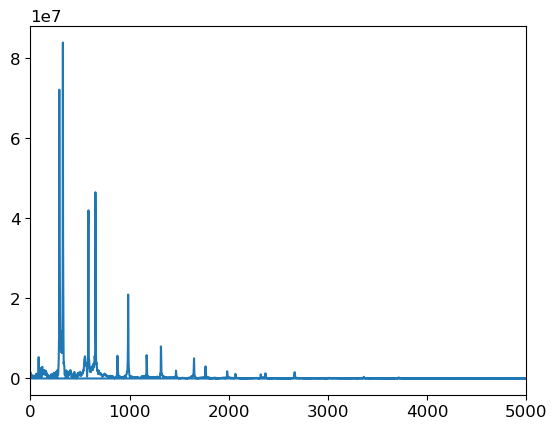

[ 292.  328.  586.  656.  986. 1172. 1316.]


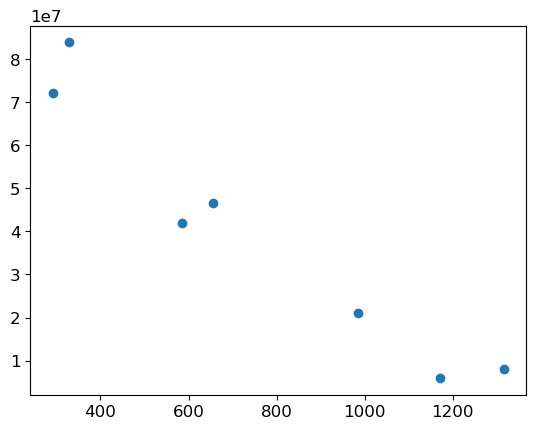

In [403]:
data = []

test = Analyzer('C_Fourth_Octave/D4E4.wav')
#test = Analyzer('All_C_1/1_7.wav')

x_fft, fft_arr = test.fft()
plt.plot(x_fft,np.abs(fft_arr))
plt.xlim(0,5000)
plt.show()

freqs, amplitudes = filter_signal(x_fft,np.abs(fft_arr))
data.append(freqs)
print(freqs)

plt.scatter(freqs,amplitudes)
plt.show()

# Model and Optimization

In [404]:
from scipy.stats import norm

In [419]:
# constants
N = len(data)
LATENT_SPACE_MAX = 2 ** NUM_FREQS - 1
num_iter = 100

# parameter initializations
#variance = 1000 ** 2 # large number so likelihoods aren't initially 0...
#pi_params = np.full((N, LATENT_SPACE_MAX-1), 1/30)
#fo_params = np.full((N,2),np.array([5000/3,5000/3*2])) # split the 0-5000 range

variance = 50 ** 2 # large number so likelihoods aren't initially 0...
pi_params = np.full((N, LATENT_SPACE_MAX-1), 1/30)
fo_params = np.full((N,2),np.array([200,300])) # split the 0-5000 range

In [420]:
# returns z as a string in binary notation
def compute_v(z):
    v = bin(z)[2:].zfill(NUM_FREQS)
    return np.array([int(j) for j in list(v)])

# returns array of counts of 1s seen in v by index i; count of 0s is then i - counts[i] for each i
def compute_counts(v):
    counts = []
    cur_count = 0
    for i in range(len(v)):
        cur_count += int(v[i])
        counts.append(cur_count)
    return np.array(counts)

# computes likelihoods for data point n over all z
# returns array of likelihoods
def compute_likelihoods(n):
    likelihoods = []
    for z in range(1,LATENT_SPACE_MAX):
        v = compute_v(z)
        counts = compute_counts(v)
        
        prod = 1
        for i in range(NUM_FREQS):
            count = counts[i] * v[i] + (i - counts[i]) * (1 - v[i]) # counts[i] if v[i] == 1; (i - counts[i]) if v[i] == 0
            prod *= norm.pdf(data[n][i],loc=fo_params[n,v[i]] * count,scale=np.sqrt(variance))
        likelihoods.append(prod)
    return np.array(likelihoods)
        

# computes component responsibilities for data point n over all z
# returns array of r values
def compute_r(n):
    likelihoods = compute_likelihoods(n)
    return np.array([likelihoods[z-1] * pi_params[n,z-1] / likelihoods.dot(pi_params[n]) for z in range(1,LATENT_SPACE_MAX)])

# computes Fo updates for data point n
# returns array of shape (2,)
def compute_Fo_updates(n,r_values):
    updated_Fo = []
    for j in range(2):
        total_sum_num = 0
        total_sum_denom = 0
        for z in range(1,LATENT_SPACE_MAX):
            v = compute_v(z)
            counts = compute_counts(v)
            
            i_selector = v * j + (1 - v) * (1 - j) # v when j == 1; (1 - v) when j == 0
            selected_counts = counts * j + (np.arange(1,NUM_FREQS+1) - counts) * (1 - j)
            sum_fs = np.dot(i_selector,data[n])
            sum_Cs = np.dot(i_selector, selected_counts)
            
            total_sum_num += r_values[n,z-1] * sum_fs
            total_sum_denom += r_values[n,z-1] * sum_Cs
        #
        updated_Fo.append(total_sum_num / total_sum_denom)
    #
    return np.array(updated_Fo)
            
def compute_variance_update(r_values):
    total_sum_num = 0
    total_sum_denom = 0
    for n in range(N):
        for z in range(1,LATENT_SPACE_MAX):
            v = compute_v(z)
            counts = compute_counts(v)
            
            sum_num = 0
            for i in range(NUM_FREQS):
                count = counts[i] * v[i] + (i - counts[i]) * (1 - v[i]) # counts[i] if v[i] == 1; (i - counts[i]) if v[i] == 0
                sum_num += (data[n][i] - fo_params[n,v[i]] * count) ** 2
            
            total_sum_num += r_values[n,z-1] * sum_num
            total_sum_denom += r_values[n,z-1] * NUM_FREQS
        #
    #
    return total_sum_num / total_sum_denom

In [421]:
# Expectation Maximization
for _ in range(num_iter):
    # E-Step
    r_values = np.array([compute_r(n) for n in range(N)])
    
    # M-Step: update component importance params
    pi_params = r_values
    
    # update Fo params
    fo_params = np.array([compute_Fo_updates(n,r_values) for n in range(N)])
    
    # update variance
    variance = compute_variance_update(r_values)

In [422]:
print(fo_params)
print(variance)

[[206.66666667 314.4       ]]
35598.19682539683


In [426]:
print(pi_params[0,pi_params[0].argmax()])
print(pi_params[0].argmax())

1.0
30
